# Тестовое задание | Кутивадзе Георгий

**Задача**:

Выполнить оценку работы библиотеки по извлечению текста новости:
- Необходимо определить полноту извлекаемого текста;
- Оценить значимость тех частей текста, которые выделить не удалось;
- Проанализировать и предложить изменения в алгоритм работы библиотеки.
 
**Желаемый результат**:

Заполненная таблица c:

- эталоном текста для каждой новости;
- результатами оценки полноты (сравнения эталона текста и текста, извлеченного библиотекой);
- оценкой значимости текста, который выделить не удалось;
- комментариями, если есть предложения по улучшению.

## Загрузка и предобработка данных

In [1]:
# загружаем библиотеки
import pandas as pd
from newspaper import Article
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords as nltk_stopwords
import nltk

/opt/anaconda3/envs/kasp_test_env/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/kasp_test_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# импортируем данные
data = pd.read_excel('Test_check.xlsx')

In [3]:
# в данных 50 элемнтов
len(data)

50

In [4]:
# пропусков нет
data.isna().sum()

URL         0
lib_text    0
dtype: int64

In [5]:
# первый столбец - ссылка, второй - извлеченный библиотекой текст новости
data.head()

,URL,lib_text
0,https://expert.ru/ekonomika/vygodna-li-rossii-...,Серьезнее других от введения западных санкций ...
1,https://ria.ru/20250311/klyuchevaya_stavka-196...,"МОСКВА, 14 фев — РИА Новости Ключевая процентн..."
2,https://expert.ru/mnenie/denis-manturov-gosuda...,Со следующего года начнется реализация 12 мега...
3,https://ria.ru/20250304/kredity-2003042476.html,Самозапрет на кредиты - это новая возможность ...
4,https://lenta.ru/brief/2025/03/11/green/,"Заходя в магазин, вы часто замечали зеленые уп..."


## Оценка работы по извлючению текста из новости

Как определено в задаче, оценка должна состоять из таких аспектов, как `Полнота` и `Значимость не выделенного текста`. Для их реализации сперва запарсим новости и создатим в нашей таблице столбец с полным текстом новости.

In [6]:
# Функция для парсинга новостей по url

def get_full_text(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        return article.text
    except:
        return ''

In [7]:
# применим функцию ко всем ссылкам
data['full_text'] = data['URL'].apply(get_full_text)

In [8]:
# взглянем на обновленный датасет
data.head()

,URL,lib_text,full_text
0,https://expert.ru/ekonomika/vygodna-li-rossii-...,Серьезнее других от введения западных санкций ...,Новая команда президента США Трампа почти сраз...
1,https://ria.ru/20250311/klyuchevaya_stavka-196...,"МОСКВА, 14 фев — РИА Новости Ключевая процентн...",https://ria.ru/20250525/klyuchevaya_stavka-196...
2,https://expert.ru/mnenie/denis-manturov-gosuda...,Со следующего года начнется реализация 12 мега...,В начале июля в Екатеринбурге состоится выстав...
3,https://ria.ru/20250304/kredity-2003042476.html,Самозапрет на кредиты - это новая возможность ...,https://ria.ru/20250430/kredity-2003042476.htm...
4,https://lenta.ru/brief/2025/03/11/green/,"Заходя в магазин, вы часто замечали зеленые уп...",4\n\nКакие компании уже уличали в гринвошинге?...


Теперь можно переходить к оценке.

### Оценка полноты

Для оценки полноты напишем функцию, которая преобразует новости в векторные представления (эмбеддинги) и оценивает их семантическую схожесть (другими словами считает косинусное сходство векторов). Таким образом, чем ближе значение к 1, тем больше извлечённый текст будет "покрывает" смысл полного текста.

In [9]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def completeness_score(extracted, full):
    if not extracted or not full:
        return 0
    emb_ext = model.encode(extracted, convert_to_tensor=True)
    emb_full = model.encode(full, convert_to_tensor=True)
    return float(util.cos_sim(emb_ext, emb_full))

In [10]:
data['completeness_score'] = data.apply(lambda row: completeness_score(row['lib_text'], row['full_text']), axis=1)

Взглянем на обновленную таблицу:

In [11]:
data.head()

,URL,lib_text,full_text,completeness_score
0,https://expert.ru/ekonomika/vygodna-li-rossii-...,Серьезнее других от введения западных санкций ...,Новая команда президента США Трампа почти сраз...,0.963758
1,https://ria.ru/20250311/klyuchevaya_stavka-196...,"МОСКВА, 14 фев — РИА Новости Ключевая процентн...",https://ria.ru/20250525/klyuchevaya_stavka-196...,0.823774
2,https://expert.ru/mnenie/denis-manturov-gosuda...,Со следующего года начнется реализация 12 мега...,В начале июля в Екатеринбурге состоится выстав...,0.978006
3,https://ria.ru/20250304/kredity-2003042476.html,Самозапрет на кредиты - это новая возможность ...,https://ria.ru/20250430/kredity-2003042476.htm...,0.853931
4,https://lenta.ru/brief/2025/03/11/green/,"Заходя в магазин, вы часто замечали зеленые уп...",4\n\nКакие компании уже уличали в гринвошинге?...,0.806705


### Извлечение «непокрытого» текста

Для оценки того, что осталось неучтённым, напишем функцию, которая сравнивает извлечённый и полный тексты, находит все совпадающие фрагменты и возвращает те части полного текста, которые не были затронуты в извлечённом:

In [12]:
# функция, возвращающая неучтенный текст

def get_uncovered_text(full, extracted):
    matcher = SequenceMatcher(None, extracted, full)
    blocks = matcher.get_matching_blocks()
    extracted_indices = [(block.b, block.b + block.size) for block in blocks]
    
    uncovered = ''
    prev_end = 0
    for start, end in extracted_indices:
        uncovered += full[prev_end:start]
        prev_end = end
    uncovered += full[prev_end:]
    return uncovered.strip()

In [13]:
# применим функцию ко всем новостям
data['uncovered_text'] = data.apply(lambda row: get_uncovered_text(row['full_text'], row['lib_text']), axis=1)

Взглянем на обновленную таблицу:

In [14]:
data.head()

,URL,lib_text,full_text,completeness_score,uncovered_text
0,https://expert.ru/ekonomika/vygodna-li-rossii-...,Серьезнее других от введения западных санкций ...,Новая команда президента США Трампа почти сраз...,0.963758,Новая команда президента США Трампа почти сраз...
1,https://ria.ru/20250311/klyuchevaya_stavka-196...,"МОСКВА, 14 фев — РИА Новости Ключевая процентн...",https://ria.ru/20250525/klyuchevaya_stavka-196...,0.823774,https://ria.ru/20250525/klyuchevaya_stavka-196...
2,https://expert.ru/mnenie/denis-manturov-gosuda...,Со следующего года начнется реализация 12 мега...,В начале июля в Екатеринбурге состоится выстав...,0.978006,В начале июля в Екатеринбурге состоится выстав...
3,https://ria.ru/20250304/kredity-2003042476.html,Самозапрет на кредиты - это новая возможность ...,https://ria.ru/20250430/kredity-2003042476.htm...,0.853931,https://ria.ru/0430/kredity-2003042476.html\n\...
4,https://lenta.ru/brief/2025/03/11/green/,"Заходя в магазин, вы часто замечали зеленые уп...",4\n\nКакие компании уже уличали в гринвошинге?...,0.806705,4\n\nКакие компании уже улили ве?\n\n\n\n\n\n\...


## Оценка значимости не извлеченного текста

Применим два способа для оценки значимости - суммарное значение `TF-IDF` и `семантическую близость`.

### Cуммарная TF-IDF-значимость

В рамках первого способа измерим важность по TF-IDF или частоте ключевых слов. В качестве оценки будет выступать суммарную TF-IDF-значимость топ-5 популярных слов.

In [15]:
nltk.download('stopwords')
russian_stopwords = list(nltk_stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/georgijkutivadze/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def get_tfidf_significance(texts, n=5):
    tfidf = TfidfVectorizer(stop_words=russian_stopwords)
    tfidf_matrix = tfidf.fit_transform(texts)
    feature_names = tfidf.get_feature_names_out()

    def significance_for_index(i):
        row = tfidf_matrix[i].toarray()[0]
        total = sorted(row, reverse=True)[:n]
        total = sum(total)
        return total

    return significance_for_index

In [17]:
texts = data['uncovered_text'].fillna('').tolist()

# Получим функцию, которая знает, как считать значимость по TF-IDF
sig_fn = get_tfidf_significance(texts)

# Применяем к каждой новости по индексу
data['tfidf_significance'] = [sig_fn(i) for i in range(len(data))]

Взглянем на обновленную таблицу:

In [18]:
data.head()

,URL,lib_text,full_text,completeness_score,uncovered_text,tfidf_significance
0,https://expert.ru/ekonomika/vygodna-li-rossii-...,Серьезнее других от введения западных санкций ...,Новая команда президента США Трампа почти сраз...,0.963758,Новая команда президента США Трампа почти сраз...,1.060521
1,https://ria.ru/20250311/klyuchevaya_stavka-196...,"МОСКВА, 14 фев — РИА Новости Ключевая процентн...",https://ria.ru/20250525/klyuchevaya_stavka-196...,0.823774,https://ria.ru/20250525/klyuchevaya_stavka-196...,1.397979
2,https://expert.ru/mnenie/denis-manturov-gosuda...,Со следующего года начнется реализация 12 мега...,В начале июля в Екатеринбурге состоится выстав...,0.978006,В начале июля в Екатеринбурге состоится выстав...,1.184461
3,https://ria.ru/20250304/kredity-2003042476.html,Самозапрет на кредиты - это новая возможность ...,https://ria.ru/20250430/kredity-2003042476.htm...,0.853931,https://ria.ru/0430/kredity-2003042476.html\n\...,1.365359
4,https://lenta.ru/brief/2025/03/11/green/,"Заходя в магазин, вы часто замечали зеленые уп...",4\n\nКакие компании уже уличали в гринвошинге?...,0.806705,4\n\nКакие компании уже улили ве?\n\n\n\n\n\n\...,1.262709


### Семантическая близость

Оценим семантическую близость схожим образом с тем, как мы считали выше полноту. Разница будет в том, что мы будем оценить косинусовые расстояние между TF-IDF векторными представлениями (дело в том, что нам важно учесть количество слов, а также важность каждого слова в документе).

Для этого также напишем функцию:

In [19]:
def semantic_difference(extracted, full):
    if not extracted or not full:
        return 1.0  # максимум расхождения
    vect = TfidfVectorizer(stop_words=russian_stopwords)
    try:
        tfidf = vect.fit_transform([extracted, full])
        sim = cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]
        return 1 - sim  # чем больше, тем больше потеряно
    except:
        return 1.0

In [20]:
# применим функцию к новостям
data['semantic_gap'] = data.apply(lambda row: semantic_difference(row['lib_text'], row['full_text']), axis=1)

In [21]:
# взглянем на обновленный датасет
data.head()

,URL,lib_text,full_text,completeness_score,uncovered_text,tfidf_significance,semantic_gap
0,https://expert.ru/ekonomika/vygodna-li-rossii-...,Серьезнее других от введения западных санкций ...,Новая команда президента США Трампа почти сраз...,0.963758,Новая команда президента США Трампа почти сраз...,1.060521,0.019585
1,https://ria.ru/20250311/klyuchevaya_stavka-196...,"МОСКВА, 14 фев — РИА Новости Ключевая процентн...",https://ria.ru/20250525/klyuchevaya_stavka-196...,0.823774,https://ria.ru/20250525/klyuchevaya_stavka-196...,1.397979,0.177224
2,https://expert.ru/mnenie/denis-manturov-gosuda...,Со следующего года начнется реализация 12 мега...,В начале июля в Екатеринбурге состоится выстав...,0.978006,В начале июля в Екатеринбурге состоится выстав...,1.184461,0.020913
3,https://ria.ru/20250304/kredity-2003042476.html,Самозапрет на кредиты - это новая возможность ...,https://ria.ru/20250430/kredity-2003042476.htm...,0.853931,https://ria.ru/0430/kredity-2003042476.html\n\...,1.365359,0.265250
4,https://lenta.ru/brief/2025/03/11/green/,"Заходя в магазин, вы часто замечали зеленые уп...",4\n\nКакие компании уже уличали в гринвошинге?...,0.806705,4\n\nКакие компании уже улили ве?\n\n\n\n\n\n\...,1.262709,0.454863


## Визуализация и Выводы

Визуализируем полученные результаты.

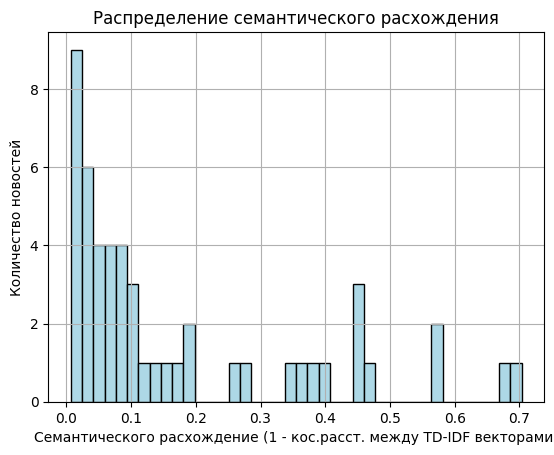

In [22]:
data['semantic_gap'].hist(bins=40, color='lightblue', edgecolor='black')
plt.title("Распределение семантического расхождения")
plt.xlabel("Семантического расхождение (1 - кос.расст. между TD-IDF векторами)")
plt.ylabel("Количество новостей")
plt.grid(True)
plt.show()

Большинство пар новостей имеют очень малое семантическое расхождение (в интервале от 0 до 0.1). Вместе с тем на графике также видно небольшое количество пар с достаточно высоким расхождением (0.6-0.7). Следует подробнее изучить подробнее эти новости и выяснить, почему библиоетека выделила не всё.

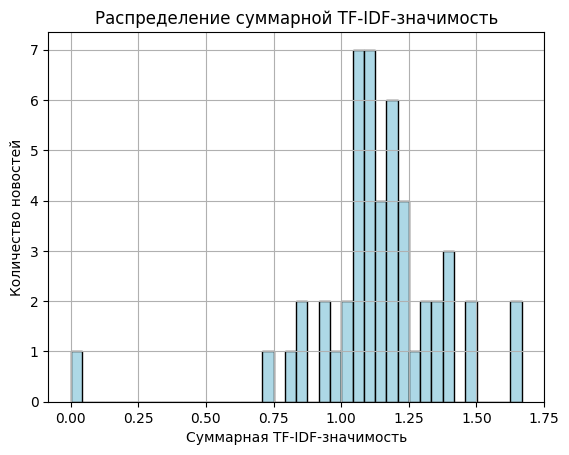

In [23]:
data['tfidf_significance'].hist(bins=40, color='lightblue', edgecolor='black')
plt.title("Распределение суммарной TF-IDF-значимость")
plt.xlabel("Суммарная TF-IDF-значимость")
plt.ylabel("Количество новостей")
plt.grid(True)
plt.show()

На данном графике можно увидеть, как распределена значимость упущенных элементов новости на основе TF-IDF. В среднем значение между 1 и 1.25.

## Вывод

Cемантическое расхождение даёт более полную картину касательно того, насколько значим тот текст, который выделит не удалось. Вместе с тем, суммарная TF-IFD в абсолютном представлении не даёт много информации, однако будет полезна при отслеживании тенденции работы библиотеки.

**Рекомендации**:
- Выбрать пороговое значение (например, 0.1–0.15) для автоматического выявления новостей, которые выделены не в достаточном в виде библиотекой
- Подробнее изучить природу тех элемнтов где значимость упущенной информации высока